In [1]:
# Importing required libraries to read, pre-process and explore the data
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

In [222]:
# Reading all the files for different network intrusion attacks - Each file contains data that has benign and a type of intrusion (DDoS, Webattack, Infiltration, PortScan, Patotor, Bot) data 
f1 = pd.read_csv('Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
f2 = pd.read_csv('Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
f3 = pd.read_csv('Friday-WorkingHours-Morning.pcap_ISCX.csv')
f4 = pd.read_csv('Monday-WorkingHours.pcap_ISCX.csv')
f5 = pd.read_csv('Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')
f6 = pd.read_csv('Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
f7 = pd.read_csv('Tuesday-WorkingHours.pcap_ISCX.csv')
f8 = pd.read_csv('Wednesday-workingHours.pcap_ISCX.csv')

In [56]:
# combining all the dataframes of different attacks into a single dataframe
attacks_df = pd.concat([f1, f2, f3, f4, f5, f6, f7, f8], ignore_index=True)

In [57]:
attacks_df[' Label'].value_counts()

 Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [58]:
# combining similar attacks into single class
types_df = attacks_df.copy()
types_df[' Label'] = types_df[' Label'].replace("Web.*", "Web Attack", regex=True)
types_df[' Label'] = types_df[' Label'].replace(r'.*Patator$', "Brute Force", regex=True)
types_df[' Label'] = types_df[' Label'].replace(["DoS GoldenEye", "DoS Hulk", "DoS Slowhttptest", "DoS slowloris"], "DoS")
types_df[' Label'].value_counts()

 Label
BENIGN          2273097
DoS              252661
PortScan         158930
DDoS             128027
Brute Force       13835
Web Attack         2180
Bot                1966
Infiltration         36
Heartbleed           11
Name: count, dtype: int64

### Intrusion Detection System

In the first multi-model ensemble system, an kind of network intrusion if present is detected (without specifying the kind of intrusion) i.e., the model detects if there is an intrusion or not.

In [95]:
# combining all the types of attacks
# intrusion - 1, benign - 0
intrusion_df = types_df.copy()

In [96]:
intrusion_df[' Label'].value_counts()

 Label
BENIGN          2273097
DoS              252661
PortScan         158930
DDoS             128027
Brute Force       13835
Web Attack         2180
Bot                1966
Infiltration         36
Heartbleed           11
Name: count, dtype: int64

#### Exploratory Data Analysis

In [97]:
# Features in the data 
intrusion_df.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [98]:
# information about the features in the data
print(intrusion_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

In [99]:
intrusion_df.head(10)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
5,54871,1022,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
6,54925,4,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
7,54925,42,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
8,9282,4,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
9,55153,4,2,0,37,0,31,6,18.5,17.67767,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [100]:
# statistical summary of the features 
intrusion_df.describe()

C:\Users\chari\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\chari\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,...,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06
mean,8.071483e+03,1.478566e+07,9.361160e+00,1.039377e+01,5.493024e+02,1.616264e+04,2.075999e+02,1.871366e+01,5.820194e+01,6.891013e+01,...,5.418218e+00,-2.741688e+03,8.155132e+04,4.113412e+04,1.531825e+05,5.829582e+04,8.316037e+06,5.038439e+05,8.695752e+06,7.920031e+06
std,1.828363e+04,3.365374e+07,7.496728e+02,9.973883e+02,9.993589e+03,2.263088e+06,7.171848e+02,6.033935e+01,1.860912e+02,2.811871e+02,...,6.364257e+02,1.084989e+06,6.485999e+05,3.933815e+05,1.025825e+06,5.770923e+05,2.363008e+07,4.602984e+06,2.436689e+07,2.336342e+07
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,1.550000e+02,2.000000e+00,1.000000e+00,1.200000e+01,0.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,3.131600e+04,2.000000e+00,2.000000e+00,6.200000e+01,1.230000e+02,3.700000e+01,2.000000e+00,3.400000e+01,0.000000e+00,...,1.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,3.204828e+06,5.000000e+00,4.000000e+00,1.870000e+02,4.820000e+02,8.100000e+01,3.600000e+01,5.000000e+01,2.616295e+01,...,2.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553500e+04,1.200000e+08,2.197590e+05,2.919220e+05,1.290000e+07,6.554530e+08,2.482000e+04,2.325000e+03,5.940857e+03,7.125597e+03,...,2.135570e+05,1.380000e+02,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


#### Pre-processing the data

##### 1. Checking and removing the rows with missing values

1358


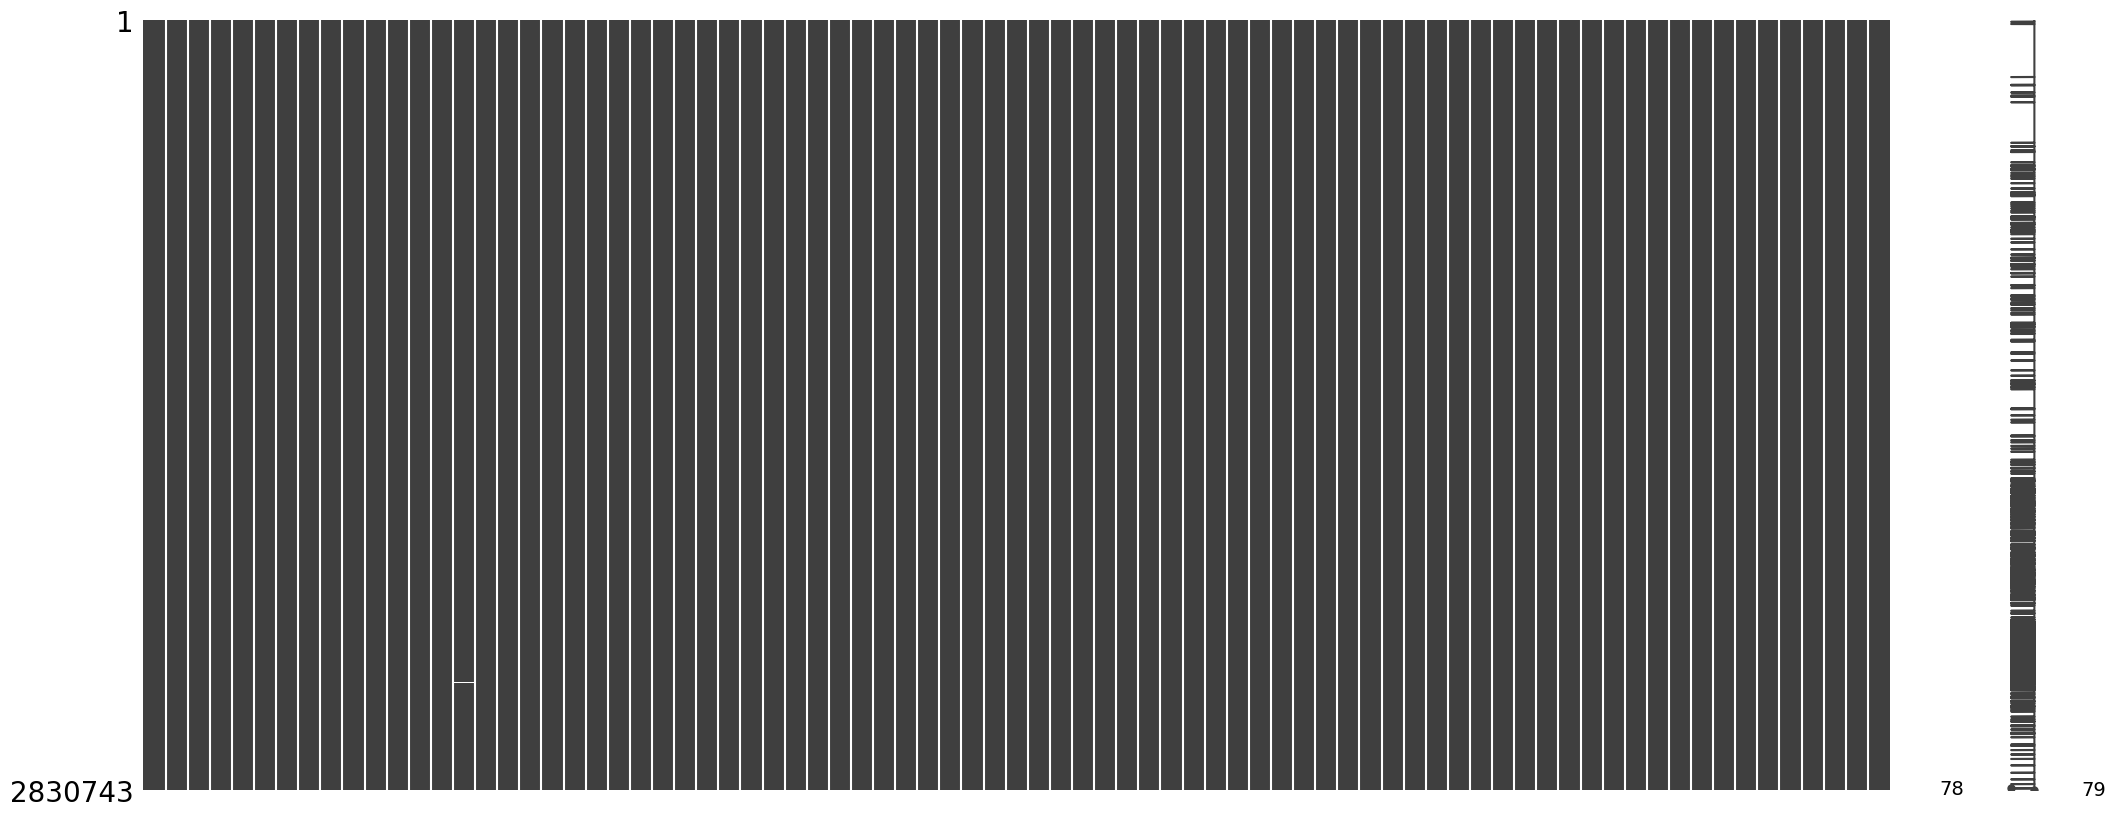

In [101]:
# Check for missing values
import missingno as msn
msn.matrix(intrusion_df)
missing_values = intrusion_df.isnull().sum().sum()
print(missing_values)

In [102]:
# Drop rows with NaN values
intrusion_df.dropna(inplace=True)
# Reset the index after dropna to ensure alignment
intrusion_df.reset_index(drop=True, inplace=True)
# Identify rows without NaN, Inf, or -Inf
indices_to_keep = ~intrusion_df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
# Filter the DataFrame to keep only valid rows
intrusion_df = intrusion_df[indices_to_keep]

In [103]:
# check for missing values again
intrusion_df.isnull().sum().sum()

np.int64(0)

##### 2. Renaming the columns properly (without any special characters and leading or trailing white spaces etc)

In [104]:
intrusion_df.columns = (
    intrusion_df.columns
    .str.strip()                    # Remove leading and trailing spaces
    .str.replace(r'[^\w\s]', '', regex=True)  # Remove special characters
    .str.replace(r'\s+', '_', regex=True)   # Replace spaces with underscores
    .str.lower()           # convert to lower-case
)

In [105]:
intrusion_df.columns

Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytess', 'flow_packetss',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags',
       'fwd_urg_flags', 'bwd_urg_flags', 'fwd_header_length',
       'bwd_header_length', 'fwd_packetss', 'bwd_packetss',
       'min_packet_length', 'max_packet_length', 'packet_length_mean',
       'packet_length_std', 'packet_length_variance', 'fin_flag_count',
       'syn_flag_count'

##### 3. Separate the features and the label columns

In [106]:
X = intrusion_df.drop('label', axis=1)  
y = intrusion_df['label'] 

print(f"Features shape: {X.shape}")
print(f"Label shape: {y.shape}")

Features shape: (2827876, 78)
Label shape: (2827876,)


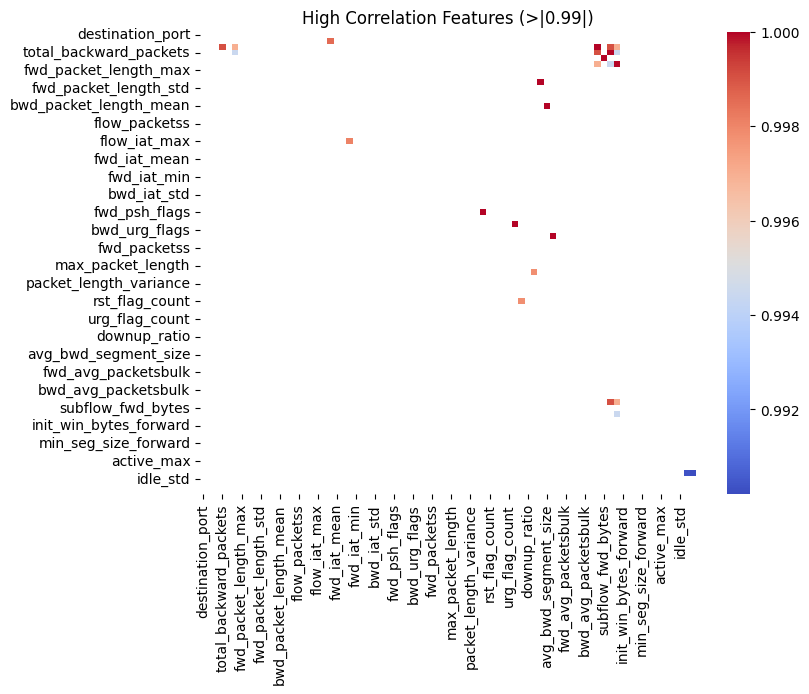

In [201]:
correlation_matrix = X.corr()

upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Filter the correlation matrix for values above 0.99
high_correlation = upper_triangle[abs(upper_triangle) > 0.99]

# Replace values below the threshold with NaN (for better visualization)
high_correlation = high_correlation.where(abs(high_correlation) > 0.99, np.nan)

# Plot the filtered correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(high_correlation, cmap='coolwarm', cbar=True, fmt=".2f")
plt.title("High Correlation Features (>|0.99|)")
plt.show()

##### 4. Eliminating the features with very high correlation 

In [107]:
##### 5. Feature Selection - Elimination of features with high correlation(which can affect model performance)
# Compute the correlation matrix
corr_matrix = X.corr().abs()
# Set a threshold for correlation
threshold = 0.99
# Find the upper triangle of the correlation matrix to avoid redundancy
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find features that are highly correlated (above the threshold)
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
# Drop the highly correlated features
X_reduced = X.drop(columns=to_drop)
print("Number of features dropped due to high correlation:", len(to_drop))
print(f"Features that are dropped due to high correlation:{to_drop}")

Number of features dropped due to high correlation: 17
Features that are dropped due to high correlation:['total_backward_packets', 'total_length_of_bwd_packets', 'fwd_iat_total', 'fwd_iat_max', 'syn_flag_count', 'cwe_flag_count', 'ece_flag_count', 'average_packet_size', 'avg_fwd_segment_size', 'avg_bwd_segment_size', 'fwd_header_length1', 'subflow_fwd_packets', 'subflow_fwd_bytes', 'subflow_bwd_packets', 'subflow_bwd_bytes', 'idle_max', 'idle_min']


##### 5. Scaling the data 

In [108]:
scaler = StandardScaler()
scaler_model = scaler.fit(X_reduced)
X_scaled = scaler.transform(X_reduced)

##### 6. Performing PCA to reduce the number of dimensions

In [109]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)

In [110]:
features_reduced = pca.fit_transform(X_scaled)

In [111]:
print("Number of features before PCA:", X_scaled.shape[1])
print("Number of features after PCA:", features_reduced.shape[1])

Number of features before PCA: 61
Number of features after PCA: 26


In [112]:
attacks = ['PortScan', 'Web Attack', 'Brute Force', 'DDoS', 'Bot','Infiltration', 'DoS', 'Heartbleed']
y_det = np.where(y.isin(attacks), 1, 0)

In [202]:
y_det

array([0, 0, 0, ..., 0, 0, 0])

In [204]:
y_det_df = pd.DataFrame(y_det, columns=['label'])

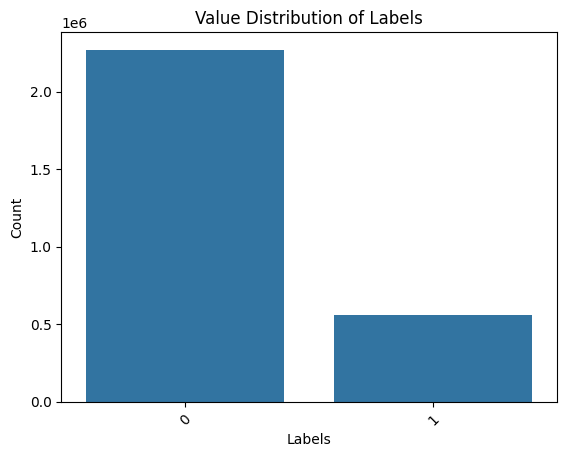

In [205]:
# class distribution in the data 
sns.countplot(data=y_det_df, x='label')

# Add labels and title
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Value Distribution of Labels")
plt.xticks(rotation=45) 
plt.show()

##### 7. Performing train test split

In [208]:
X_train, X_test, y_train, y_test = train_test_split(features_reduced, y_det, test_size = 0.2, stratify = y_det, random_state = 42)

##### 8. Create sequential data for LSTM

In [209]:
# reshape input data to LSTM [Samples, timesteps, features]
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [210]:
print(f"Generated sequences shape: {X_train_lstm.shape}")  
print(f"Generated labels shape: {y_train.shape}")   

Generated sequences shape: (2262300, 1, 26)
Generated labels shape: (2262300,)


In [211]:
#X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq, test_size = 0.2, stratify = y_seq, random_state = 42)

In [212]:
# creating split for validation 
X_train_lstm, X_val_lstm, y_train_lstm, y_val_lstm = train_test_split(X_train_lstm, y_train, test_size=0.1, stratify=y_train, random_state = 42)

#Print the class distribution in train, validation, and test sets to verify stratification
print("Training class distribution:", np.bincount(y_train_lstm))
print("Validation class distribution:", np.bincount(y_val_lstm))
print("Test class distribution:", np.bincount(y_test))

Training class distribution: [1635349  400721]
Validation class distribution: [181706  44524]
Test class distribution: [454265 111311]


#### Build the LSTM  model

In [119]:
print(X_train_lstm.shape)

(2036070, 1, 26)


In [120]:
print(y_train_lstm.shape)

(2036070,)


In [121]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))  # or return_sequences=False
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(32, return_sequences=False))  # Return False to get a 2D output
lstm_model.add(Dropout(0.2))
lstm_model.add(Flatten())
# Dense output layer
lstm_model.add(Dense(1, activation='sigmoid'))

C:\Users\chari\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [122]:
for layer in lstm_model.layers:
    print(layer.output.shape)

(None, 1, 64)
(None, 1, 64)
(None, 32)
(None, 32)
(None, 32)
(None, 1)


In [123]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 1, 64)               │          23,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,745 (139.63 KB)

 Trainable params: 35,745 (139.63 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=64, validation_data=(X_val_lstm, y_val_lstm))

Epoch 1/10
31814/31814 ━━━━━━━━━━━━━━━━━━━━ 75s 2ms/step - accuracy: 0.9601 - loss: 0.0936 - val_accuracy: 0.9751 - val_loss: 0.0532
Epoch 2/10
31814/31814 ━━━━━━━━━━━━━━━━━━━━ 75s 2ms/step - accuracy: 0.9754 - loss: 0.0542 - val_accuracy: 0.9806 - val_loss: 0.0458
Epoch 3/10
31814/31814 ━━━━━━━━━━━━━━━━━━━━ 76s 2ms/step - accuracy: 0.9779 - loss: 0.0492 - val_accuracy: 0.9784 - val_loss: 0.0443
Epoch 4/10
31814/31814 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step - accuracy: 0.9791 - loss: 0.0466 - val_accuracy: 0.9830 - val_loss: 0.0415
Epoch 5/10
31814/31814 ━━━━━━━━━━━━━━━━━━━━ 80s 3ms/step - accuracy: 0.9799 - loss: 0.0448 - val_accuracy: 0.9777 - val_loss: 0.0464
Epoch 6/10
31814/31814 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - accuracy: 0.9805 - loss: 0.0435 - val_accuracy: 0.9830 - val_loss: 0.0388
Epoch 7/10
31814/31814 ━━━━━━━━━━━━━━━━━━━━ 78s 2ms/step - accuracy: 0.9812 - loss: 0.0422 - val_accuracy: 0.9819 - val_loss: 0.0395
Epoch 8/10
31814/31814 ━━━━━━━━━━━━━━━━━━━━ 76s 2ms/step - accuracy: 

In [213]:
# To load the saved model 
lstm_model = tf.keras.models.load_model('trained_lstm__final_model.h5')

In [214]:
lstm_preds_train = lstm_model.predict(X_train_lstm)
lstm_preds_test = lstm_model.predict(X_test_lstm)

# Reshape LSTM predictions to 1D
lstm_preds_train = lstm_preds_train.ravel()
lstm_preds_test = lstm_preds_test.ravel()

63628/63628 ━━━━━━━━━━━━━━━━━━━━ 61s 940us/step
17675/17675 ━━━━━━━━━━━━━━━━━━━━ 16s 891us/step


In [215]:
from sklearn.metrics import roc_auc_score
auc_score_lstm = roc_auc_score(y_test, lstm_preds_test)

In [216]:
lstm_preds_test = (lstm_preds_test > 0.5).astype(int)

In [217]:
lstm_preds_test

array([1, 1, 1, ..., 0, 0, 0])

In [218]:
precision_macro_lstm = precision_score(y_test, lstm_preds_test, average='macro')
recall_macro_lstm = recall_score(y_test, lstm_preds_test, average='macro')
f1_macro_lstm = f1_score(y_test, lstm_preds_test, average='macro')

print(f"\nMacro-Averaged Precision: {precision_macro_lstm:.4f}")
print(f"Macro-Averaged Recall: {recall_macro_lstm:.4f}")
print(f"Macro-Averaged F1-Score: {f1_macro_lstm:.4f}")
print(f"AUC-ROC score: {auc_score_lstm:.4f}")


Macro-Averaged Precision: 0.9745
Macro-Averaged Recall: 0.9641
Macro-Averaged F1-Score: 0.9692
AUC-ROC score: 0.9984


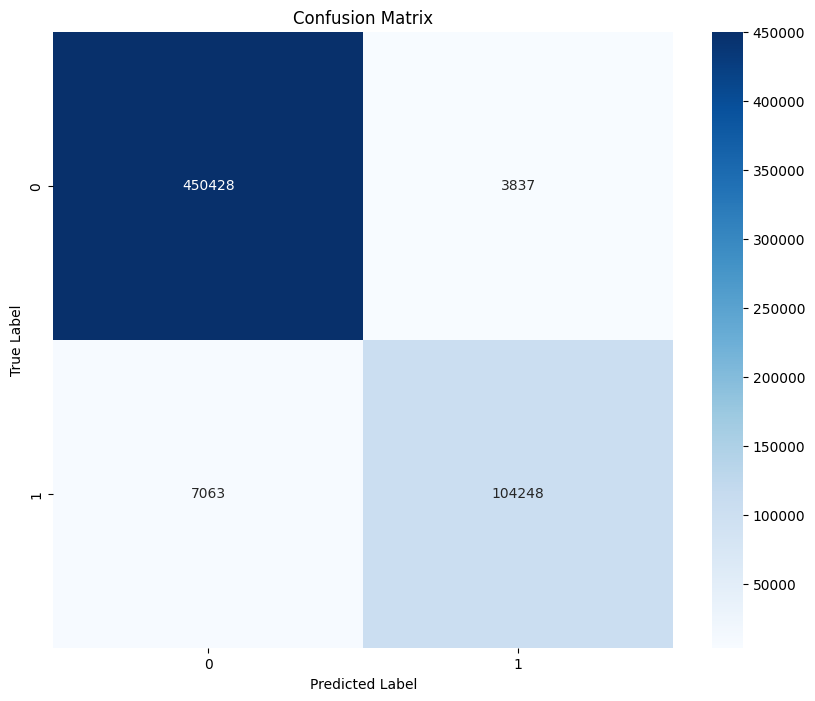

In [220]:
conf_matrix = confusion_matrix(y_test, lstm_preds_test)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [154]:
# save the model
lstm_model.save('trained_lstm__final_model.h5')

#### Isolation Forest

##### tuning hyperparameters using gridsearch for the isolation forest model

In [176]:
from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(n_estimators = 100, random_state = 42, contamination = 0.01)
iso_forest.fit(X_train)

IsolationForest(contamination=0.01, random_state=42)

In [180]:
iso_forest.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1])

In [177]:
from sklearn.preprocessing import MinMaxScaler
# Get anomaly scores and binary predictions
# Scores: decision_function (higher = normal, lower = anomalous)
iso_train_scores = iso_forest.decision_function(X_train)
iso_test_scores = iso_forest.decision_function(X_test)

# Scale scores to [0, 1] range
minmax_scaler = MinMaxScaler()
iso_train_scores_scaled = minmax_scaler.fit_transform(iso_train_scores.reshape(-1, 1))
iso_test_scores_scaled = minmax_scaler.transform(iso_test_scores.reshape(-1, 1))

# Binary labels: -1 (anomaly) -> 1, 1 (normal) -> 0
iso_train_preds = np.where(iso_forest.predict(X_train) == -1, 1, 0)
iso_test_preds = np.where(iso_forest.predict(X_test) == -1, 1, 0)

In [178]:
iso_test_preds

array([0, 0, 0, ..., 0, 0, 0])

In [179]:
from sklearn.metrics import f1_score
precision_macro_iso = precision_score(y_test, iso_test_preds, average='macro')
recall_macro_iso = recall_score(y_test, iso_test_preds, average='macro')
f1_macro_iso = f1_score(y_test, iso_test_preds, average='macro')

print(f"\nMacro-Averaged Precision: {precision_macro_iso:.4f}")
print(f"Macro-Averaged Recall: {recall_macro_iso:.4f}")
print(f"Macro-Averaged F1-Score: {f1_macro_iso:.4f}")


Macro-Averaged Precision: 0.0653
Macro-Averaged Recall: 0.1228
Macro-Averaged F1-Score: 0.0774


C:\Users\chari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
Since, Isolation forest didnot perform well 

#### Detection of Type of Attack

In [134]:
y

0          BENIGN
1          BENIGN
2          BENIGN
3          BENIGN
4          BENIGN
            ...  
2829380    BENIGN
2829381    BENIGN
2829382    BENIGN
2829383    BENIGN
2829384    BENIGN
Name: label, Length: 2827876, dtype: object

In [140]:
mask = y != 'BENIGN'  # Boolean mask where 'benign' is not included

X_filtered = features_reduced[mask]  # Filter X_reduced using the mask
y_filtered = y[mask]  # Filter y using the same mask

In [141]:
y_int = y_filtered.map({
    'DoS': 0, 'PortScan': 1, 'DDoS': 2, 'Brute Force': 3, 
    'Web Attack': 4, 'Bot': 5, 'Infiltration': 6, 'Heartbleed': 7
})

In [142]:
y_int

18880      2
18881      2
18882      2
18883      2
18884      2
          ..
2829288    0
2829295    0
2829334    0
2829363    0
2829378    0
Name: label, Length: 556556, dtype: int64

In [145]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_filtered, y_int, stratify = y_int, random_state = 42, test_size = 0.2)

In [147]:
# 5. Train a Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight = 'balanced')
rf_model.fit(X_train_rf, y_train_rf)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [148]:
y_pred = rf_model.predict(X_test_rf)

In [149]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=[
    'DoS', 'PortScan', 'DDoS', 'Brute Force', 'Web Attack', 
    'Bot', 'Infiltration', 'Heartbleed']))

Classification Report:
              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     50343
    PortScan       1.00      1.00      1.00     31761
        DDoS       1.00      1.00      1.00     25605
 Brute Force       1.00      1.00      1.00      2767
  Web Attack       0.99      0.98      0.98       436
         Bot       1.00      1.00      1.00       391
Infiltration       1.00      0.57      0.73         7
  Heartbleed       1.00      1.00      1.00         2

    accuracy                           1.00    111312
   macro avg       1.00      0.94      0.96    111312
weighted avg       1.00      1.00      1.00    111312



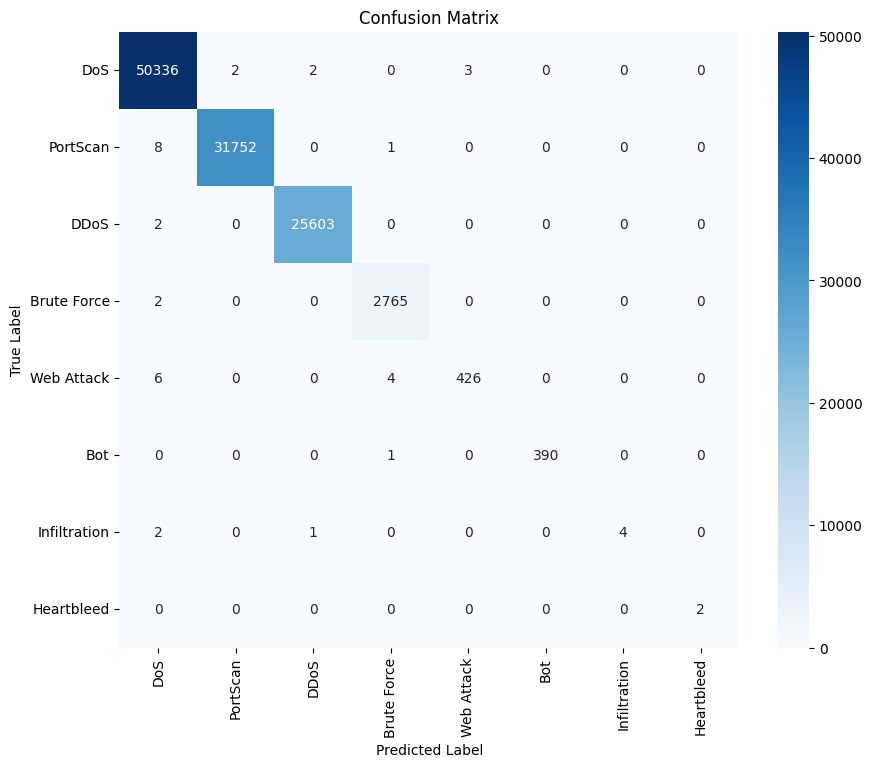

In [150]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['DoS', 'PortScan', 'DDoS', 'Brute Force', 'Web Attack', 
                         'Bot', 'Infiltration', 'Heartbleed'], 
            yticklabels=['DoS', 'PortScan', 'DDoS', 'Brute Force', 'Web Attack', 
                         'Bot', 'Infiltration', 'Heartbleed'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [153]:
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f"\nMacro-Averaged Precision: {precision_macro:.4f}")
print(f"Macro-Averaged Recall: {recall_macro:.4f}")
print(f"Macro-Averaged F1-Score: {f1_macro:.4f}")


Macro-Averaged Precision: 0.9988
Macro-Averaged Recall: 0.9431
Macro-Averaged F1-Score: 0.9636


In [185]:
# Save the random forest model
from joblib import dump
dump(rf_model, 'random_forest_model.joblib')

['random_forest_model.joblib']

#### Support Vector Machine (SVC)

In [186]:
# Initialize SVC model
from sklearn.svm import SVC
svc_model = SVC(kernel='rbf', C=1, gamma='scale', decision_function_shape='ovr')  

# Train the model
svc_model.fit(X_train_rf, y_train_rf)

SVC(C=1)

In [187]:
y_pred_svc = svc_model.predict(X_test_rf)

In [188]:
print("Classification Report:")
print(classification_report(y_test_rf, y_pred_svc, target_names=[
    'DoS', 'PortScan', 'DDoS', 'Brute Force', 'Web Attack', 
    'Bot', 'Infiltration', 'Heartbleed']))

Classification Report:
              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     50343
    PortScan       1.00      1.00      1.00     31761
        DDoS       1.00      1.00      1.00     25605
 Brute Force       0.97      0.99      0.98      2767
  Web Attack       0.98      0.87      0.92       436
         Bot       0.99      0.68      0.81       391
Infiltration       1.00      0.43      0.60         7
  Heartbleed       1.00      1.00      1.00         2

    accuracy                           1.00    111312
   macro avg       0.99      0.87      0.91    111312
weighted avg       1.00      1.00      1.00    111312



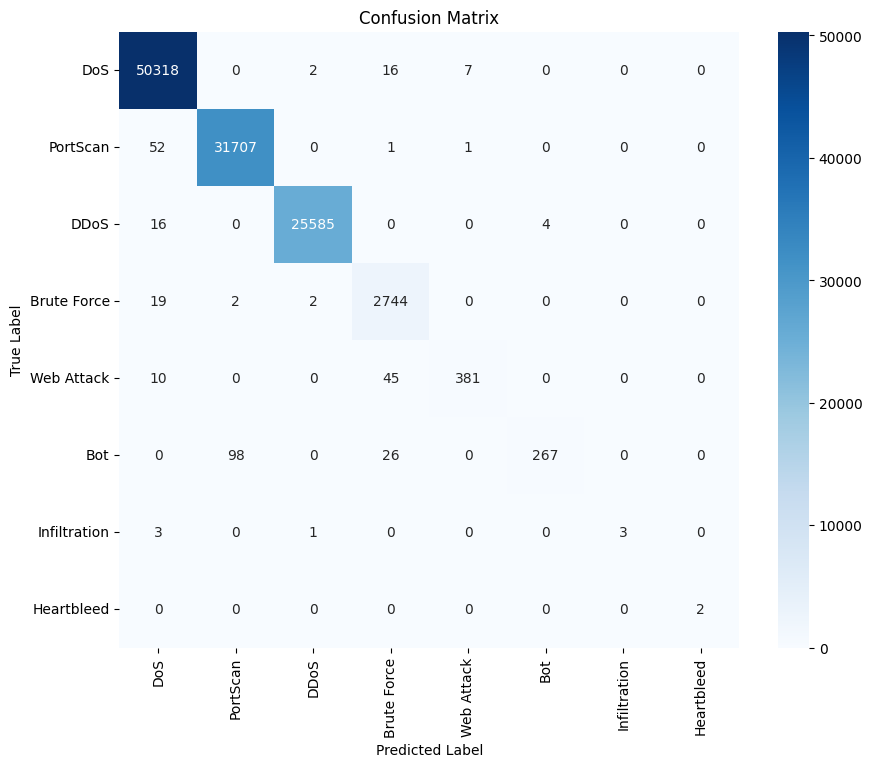

In [189]:
conf_matrix = confusion_matrix(y_test_rf, y_pred_svc)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['DoS', 'PortScan', 'DDoS', 'Brute Force', 'Web Attack', 
                         'Bot', 'Infiltration', 'Heartbleed'], 
            yticklabels=['DoS', 'PortScan', 'DDoS', 'Brute Force', 'Web Attack', 
                         'Bot', 'Infiltration', 'Heartbleed'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [190]:
precision_macro = precision_score(y_test_rf, y_pred_svc, average='macro')
recall_macro = recall_score(y_test_rf, y_pred_svc, average='macro')
f1_macro = f1_score(y_test_rf, y_pred_svc, average='macro')

print(f"\nMacro-Averaged Precision: {precision_macro:.4f}")
print(f"Macro-Averaged Recall: {recall_macro:.4f}")
print(f"Macro-Averaged F1-Score: {f1_macro:.4f}")


Macro-Averaged Precision: 0.9910
Macro-Averaged Recall: 0.8717
Macro-Averaged F1-Score: 0.9133


In [ ]:
# Save the SVM model
from joblib import dump
dump(svc_model, 'svc_model.joblib')